In [119]:
import matplotlib.pyplot as plt
import matplotlib
import scipy
import numpy as np

In [120]:
matplotlib.rcParams.update({'font.size': 22})

In [121]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [122]:
N_CHANNELS = 8191
START_LINE = 13


In [123]:
def read(spe_filename):
    """given a .Spe file, return the data as a numpy array"""
    with open(spe_filename, "r", encoding="utf-8") as spe_file:
        spe_lines = spe_file.readlines()
    data_lines = spe_lines[START_LINE:START_LINE+N_CHANNELS]
    data_nums = [int(d.strip().replace("\n", "")) for d in data_lines]
    return np.array(data_nums)

def read_time(spe_filename):
    with open(spe_filename, "r", encoding="utf-8") as spe_file:
        time_line = spe_file.readlines()[9]  # example: 245 245
        time_line = time_line.strip().replace("\n", "")
        live, real = map(int, time_line.split())
    return live, real

def live_time(spe_filename):
    return read_time(spe_filename)[0]    

In [128]:
channels = np.arange(0, N_CHANNELS, 1)


spectrum_co60 = read('data/frun3_co60_live180s.Spe')
spectrum_ba133 = read('data/frun1_ba133_live180s.Spe')
spectrum_na22 = read('data/frun2_na22_live180s.Spe')
spectrum_x = read('data/frun4_source_live5400s.Spe')

#old
spectrum_bkg = read('data/frun5_bkg_live5400s.Spe')

live_time_co60 = live_time('data/frun3_co60_live180s.Spe')
live_time_ba133 = live_time('data/frun1_ba133_live180s.Spe')
live_time_na22 = live_time('data/frun2_na22_live180s.Spe')
live_time_x = live_time('data/frun4_source_live5400s.Spe')
live_time_bkg = live_time('data/frun5_bkg_live5400s.Spe')


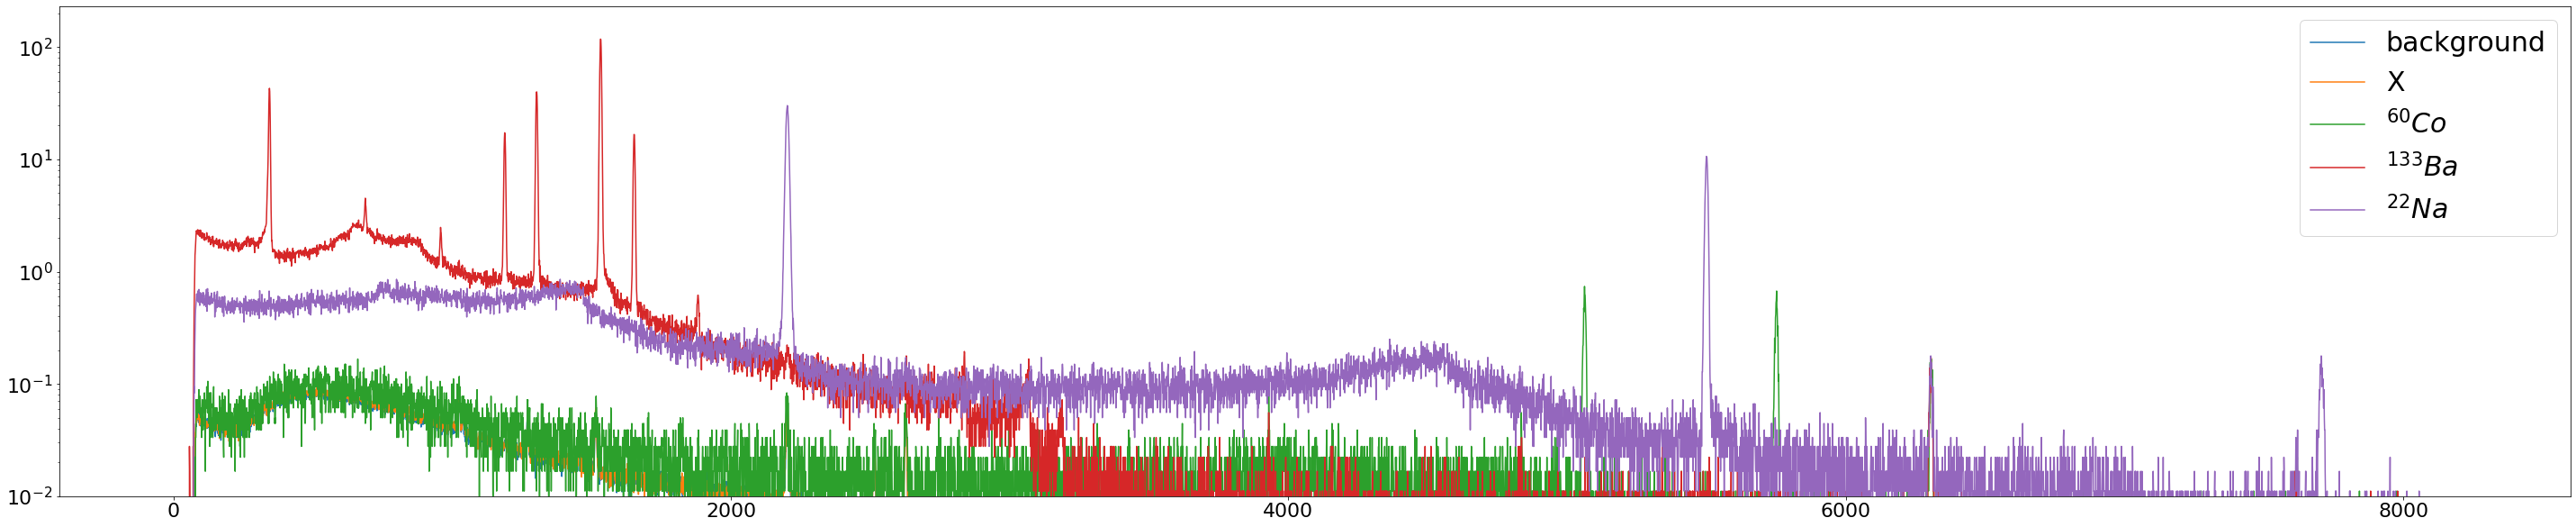

0.0007907907907907924


In [147]:
plt.figure(figsize=(50, 10))

plt.semilogy(spectrum_bkg/live_time_bkg, label=r'background')
plt.semilogy(spectrum_x/live_time_x, label=r'X')
plt.semilogy(spectrum_co60/live_time_co60, label=r'$^{60}Co$')
plt.semilogy(spectrum_ba133/live_time_ba133, label=r'$^{133}Ba$')
plt.semilogy(spectrum_na22/live_time_na22, label=r'$^{22}Na$')
plt.ylim(0.01)
# plt.xlim(5200,5300)
plt.legend(fontsize=30)
plt.show()

def activity(sample_spectrum, sample_live_time, peak_channel_range):
    start, stop = peak_channel_range
    step = 1  # channels are spaced by 1
    bkg_integral = np.sum(spectrum_bkg[start:stop]/live_time_bkg) * step
    smp_integral = np.sum(sample_spectrum[start:stop]/sample_live_time) * step
    return smp_integral - bkg_integral

sample_weight = 18.5  # g
x_activity = activity(spectrum_x, live_time_x, (5220, 5270))
activity_per_g = x_activity / sample_weight
print(activity_per_g)


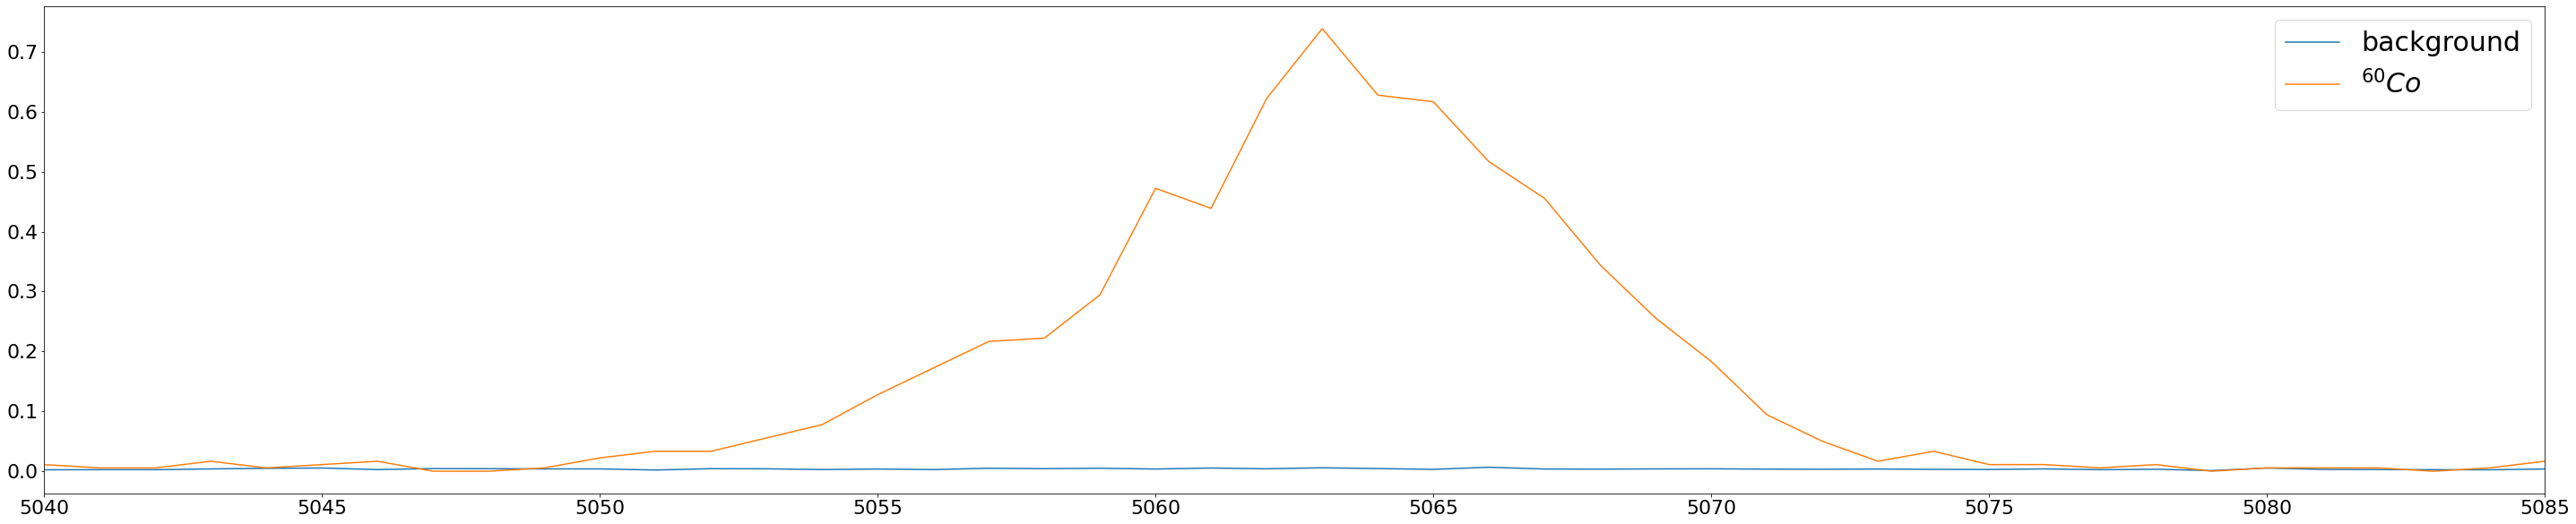

6.694259259259259


In [130]:
# activity for other known lines

plt.figure(figsize=(50, 10))
plt.plot(spectrum_bkg/live_time_bkg, label=r'background')
plt.plot(spectrum_co60/live_time_co60, label=r'$^{60}Co$')
#plt.ylim(0,0.5)
peak = 5063
peak_range_1 = (5040, 5085)
plt.xlim(*peak_range_1)
#plt.xlim(5752-100, 5752+100)
plt.legend(fontsize=30)
plt.show()

activity_peak_1 = activity(spectrum_co60, live_time_co60, peak_range_1)
print(activity_peak_1)

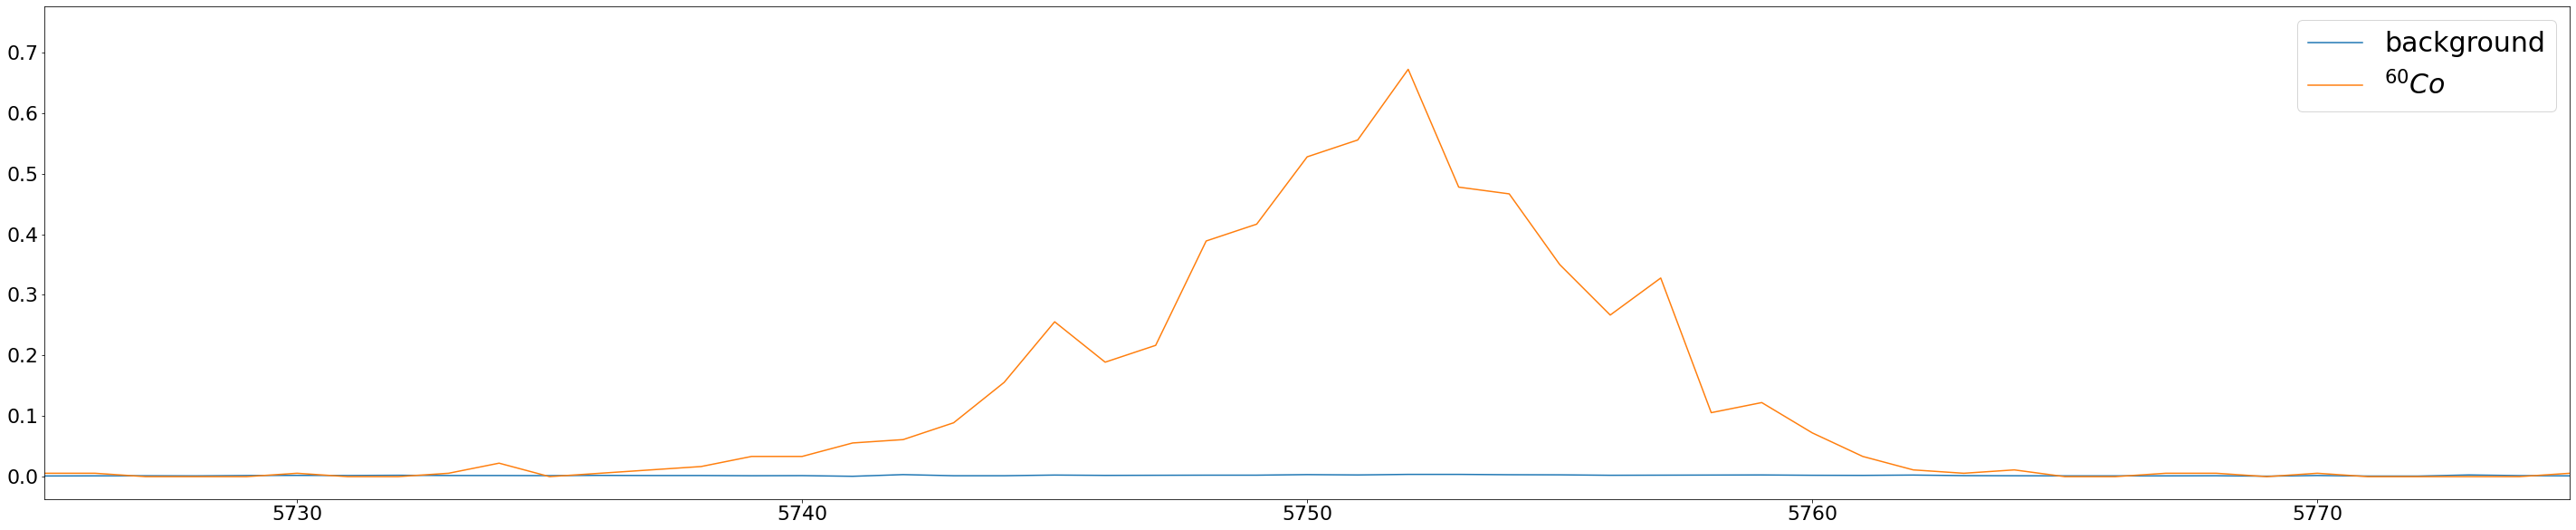

5.894629629629629


In [131]:
plt.figure(figsize=(50, 10))
plt.plot(spectrum_bkg/live_time_bkg, label=r'background')
plt.plot(spectrum_co60/live_time_co60, label=r'$^{60}Co$')
peak = 5752
peak_range_2 = (5725, 5775)
plt.xlim(*peak_range_2)
plt.legend(fontsize=30)
plt.show()

activity_peak_2 = activity(spectrum_co60, live_time_co60, peak_range_2)
print(activity_peak_2)

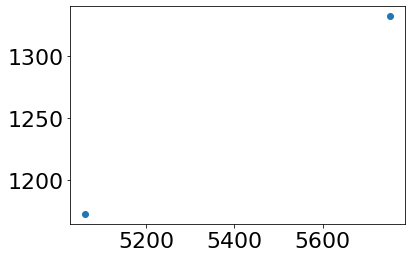

In [132]:
peaks = [
    # (channel, keV) -- manually identified
    (5063, 1173),  # Co60
    (5752, 1332),  # Co60
    #(1292, 356),  # Ba133
    #(1100, 303),  # Ba133
    #(303, 81),  # Ba133
]
peak_channels, peak_energies = list(zip(*peaks))
plt.scatter(peak_channels, peak_energies)

line = np.polyfit(peak_channels, peak_energies, deg=1)
energies = np.polyval(line, channels)


113.49925925925925


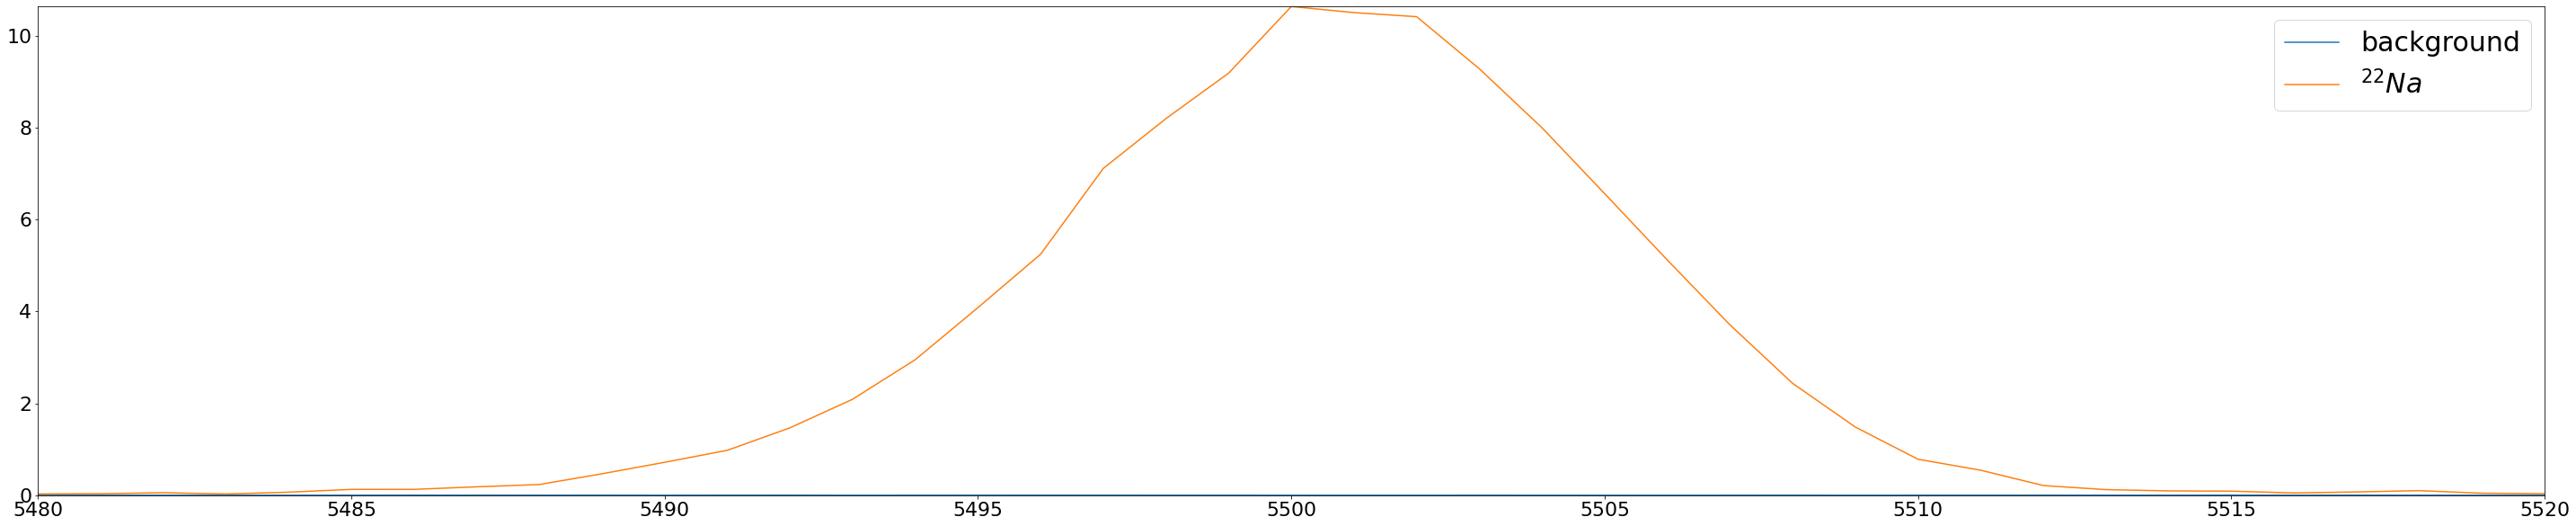

In [133]:
peak_guess = 5500
guess_tol = 20
spectrum = spectrum_na22
spectrum_time = live_time_na22
plt.figure(figsize=(50, 10))
plt.plot(spectrum_bkg/live_time_bkg, label=r'background')
plt.plot(spectrum/spectrum_time, label=r'$^{22}Na$')
peak_range = (peak_guess-guess_tol, peak_guess+guess_tol)
plt.ylim(0,spectrum[peak_guess]/spectrum_time)
plt.xlim(*peak_range)
plt.legend(fontsize=30)
activity_peak = activity(spectrum, spectrum_time, peak_range)
print(activity_peak)

activity at 358.38461538461763 keV: 864.742037037037


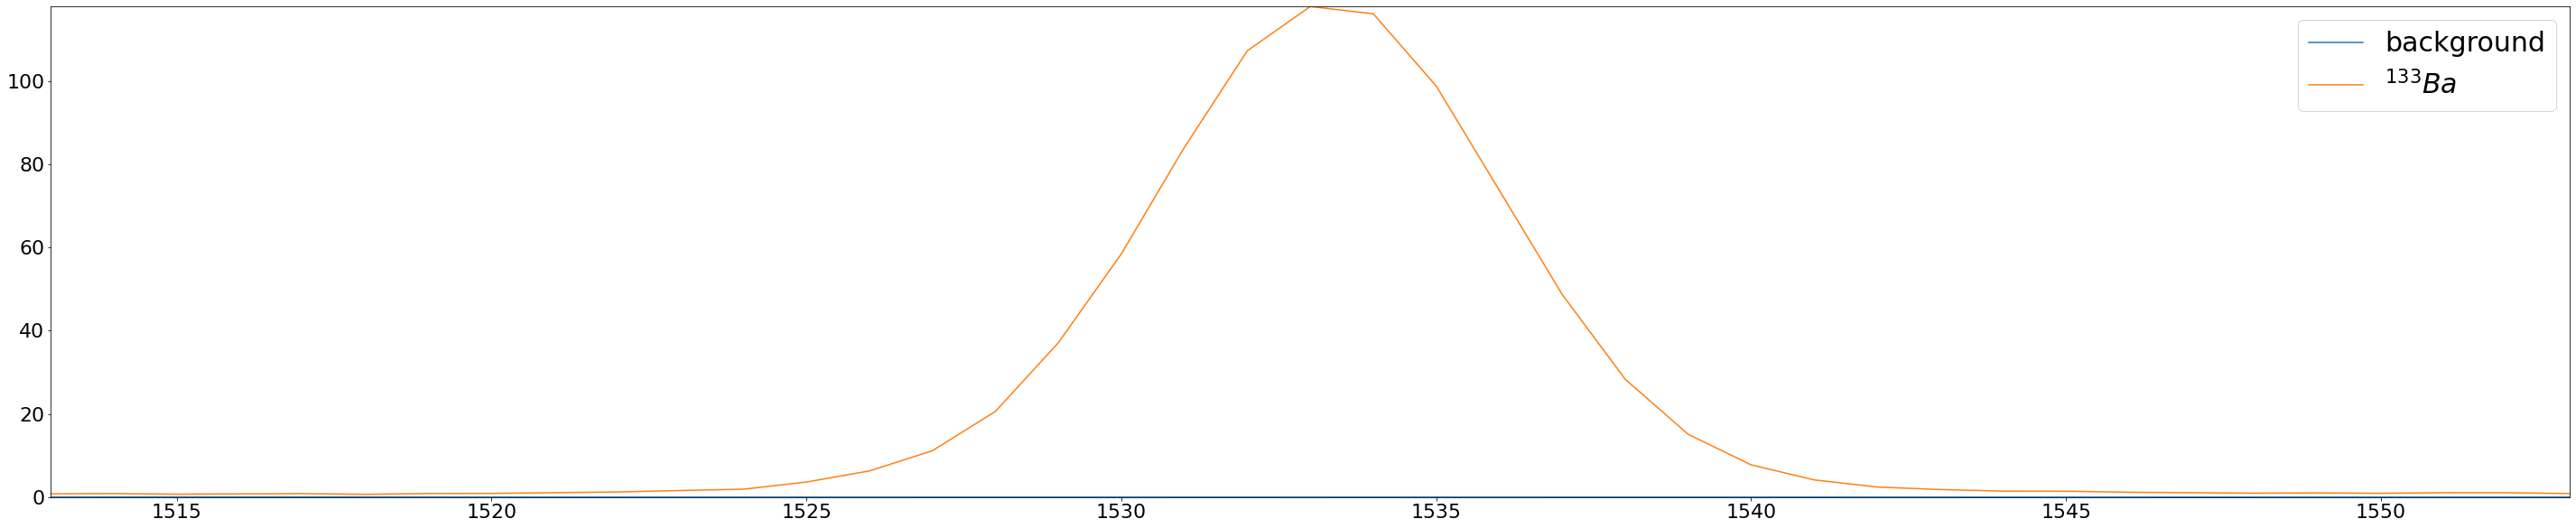

In [134]:

def energy_from_channel(channel):
    return line[0]*channel + line[1]

def channel_from_energy(energy):
    return (energy - line[1])/line[0]

peak_guess = 1533
guess_tol = 20
spectrum = spectrum_ba133
spectrum_time = live_time_ba133
plt.figure(figsize=(50, 10))
plt.plot(spectrum_bkg/live_time_bkg, label=r'background')
plt.plot(spectrum/spectrum_time, label=r'$^{133}Ba$')
peak_range = (peak_guess-guess_tol, peak_guess+guess_tol)
plt.ylim(0,spectrum[peak_guess]/spectrum_time)
plt.xlim(*peak_range)
plt.legend(fontsize=30)
activity_peak = activity(spectrum, spectrum_time, peak_range)
print(f"activity at {energy_from_channel(peak_guess)} keV: {activity_peak}")

activity at 358.38461538461763 keV: 864.742037037037


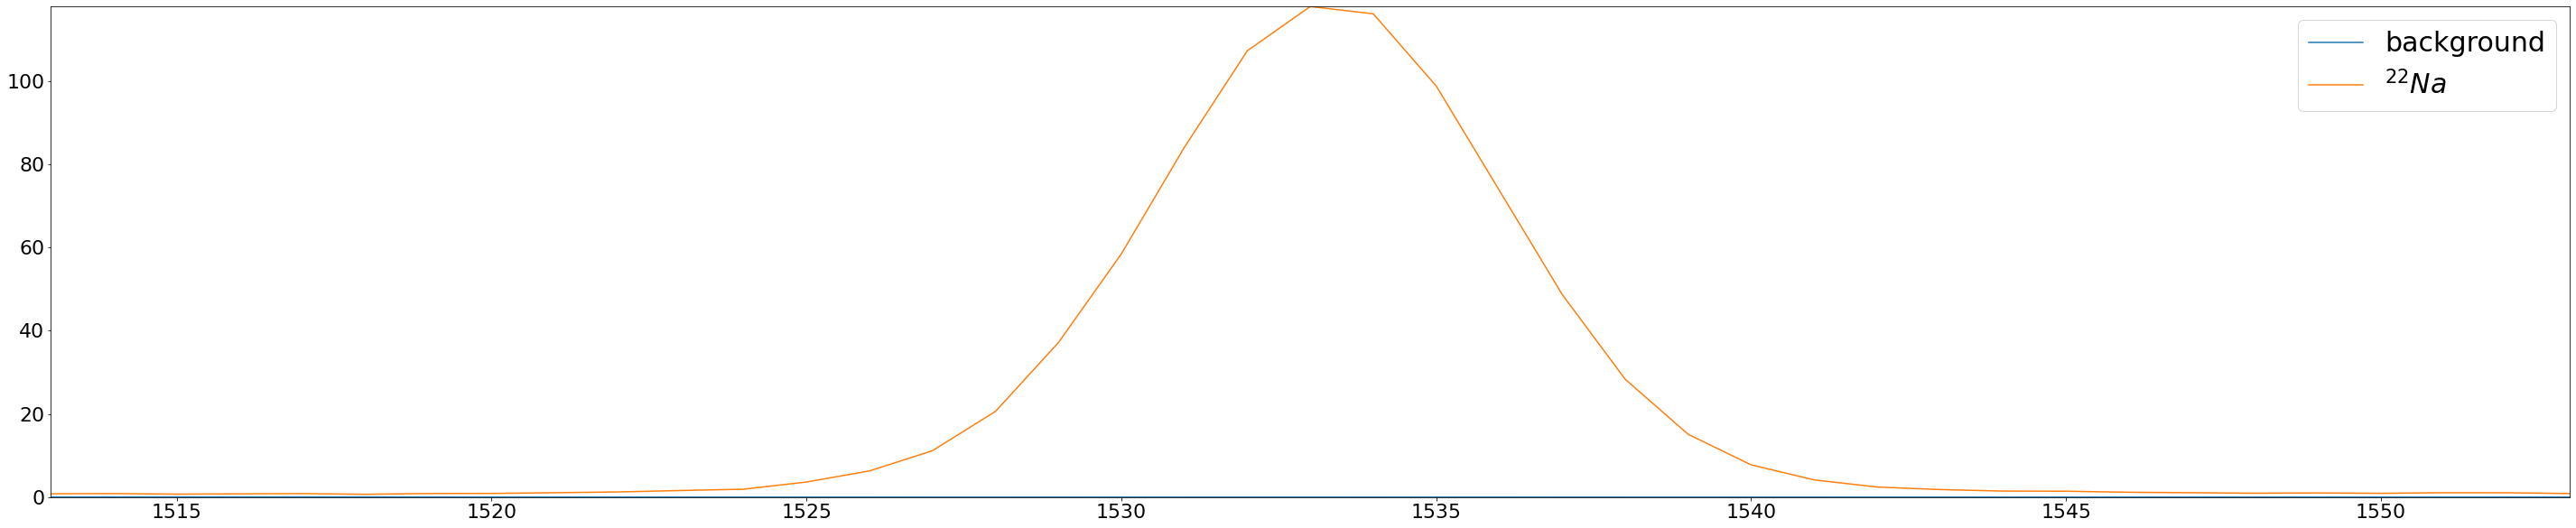

In [135]:

def energy_from_channel(channel):
    return line[0]*channel + line[1]

def channel_from_energy(energy):
    return (energy - line[1])/line[0]

peak_guess = 1533
guess_tol = 20
spectrum = spectrum_ba133
spectrum_time = live_time_ba133
plt.figure(figsize=(50, 10))
plt.plot(spectrum_bkg/live_time_bkg, label=r'background')
plt.plot(spectrum/spectrum_time, label=r'$^{22}Na$')
peak_range = (peak_guess-guess_tol, peak_guess+guess_tol)
plt.ylim(0,spectrum[peak_guess]/spectrum_time)
plt.xlim(*peak_range)
plt.legend(fontsize=30)
activity_peak = activity(spectrum, spectrum_time, peak_range)
print(f"activity at {energy_from_channel(peak_guess)} keV: {activity_peak}")

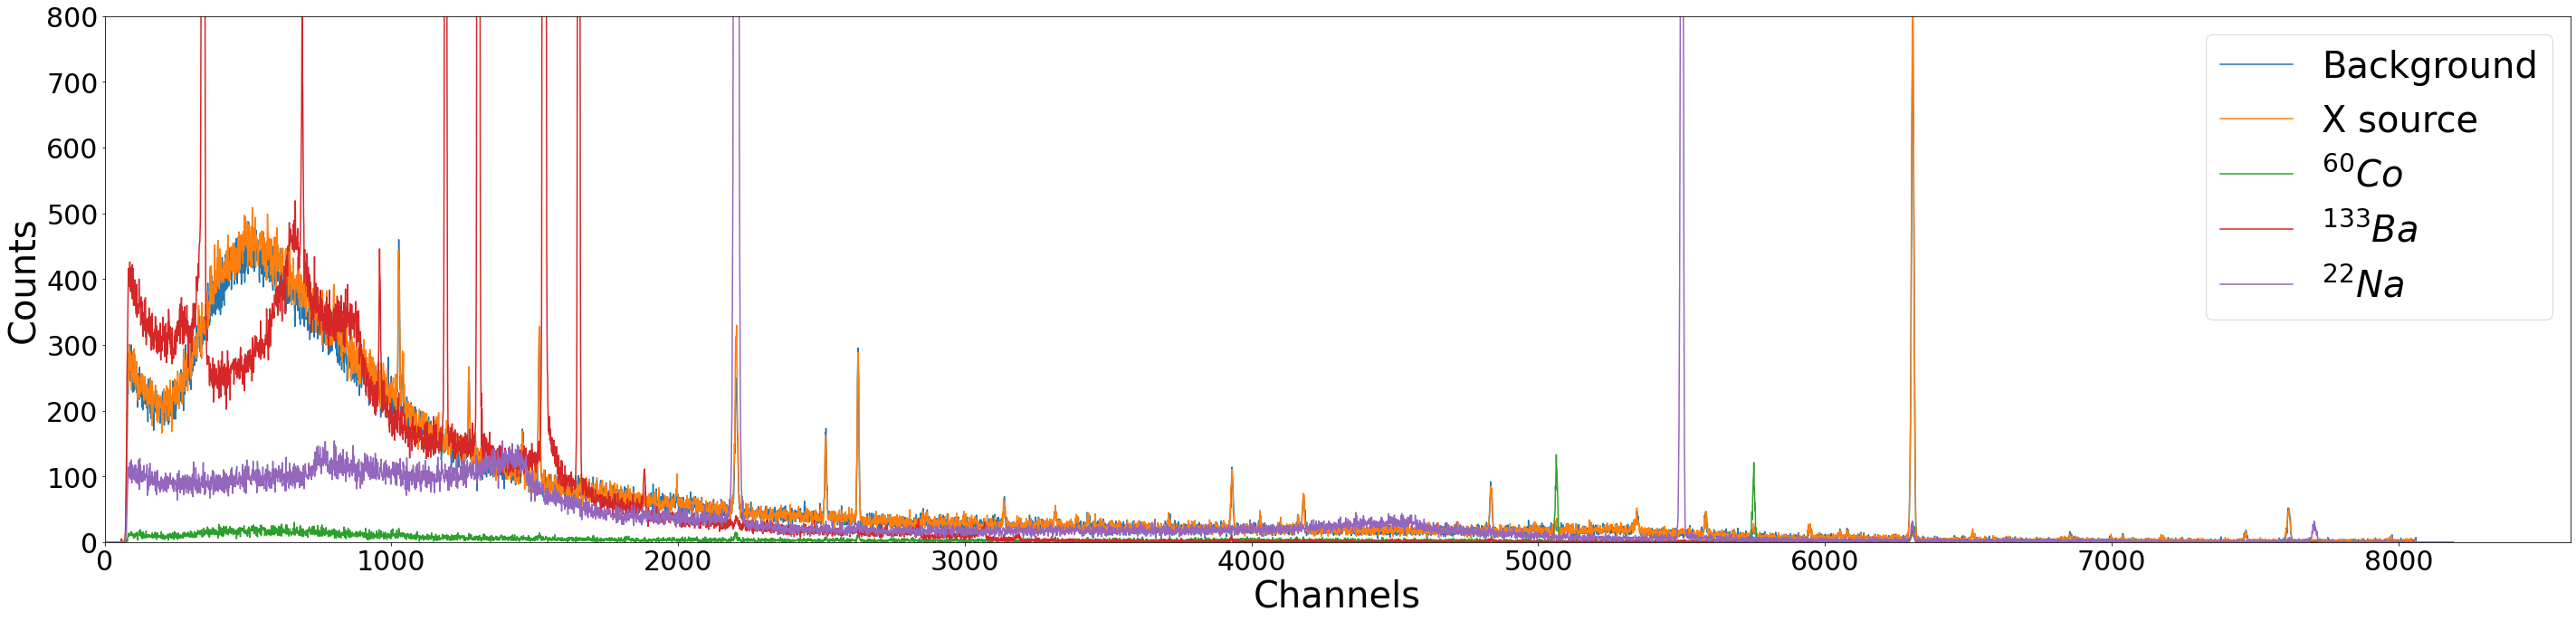

In [165]:
plt.figure(figsize=(40, 10))

plt.plot(spectrum_bkg, label=r'Background')
plt.plot(spectrum_x, label=r'X source')
plt.plot(spectrum_co60, label=r'$^{60}Co$')
plt.plot(spectrum_ba133, label=r'$^{133}Ba$')
plt.plot(spectrum_na22, label=r'$^{22}Na$')

plt.xlabel("Channels", fontsize=40)
plt.ylabel("Counts", fontsize=40)
plt.legend(fontsize=40)
plt.xticks(fontsize=30)
plt.yticks(fontsize=30)
plt.ylim(0, 800)
plt.xlim(0)
plt.tight_layout()
plt.savefig('rawSpectrum.png')

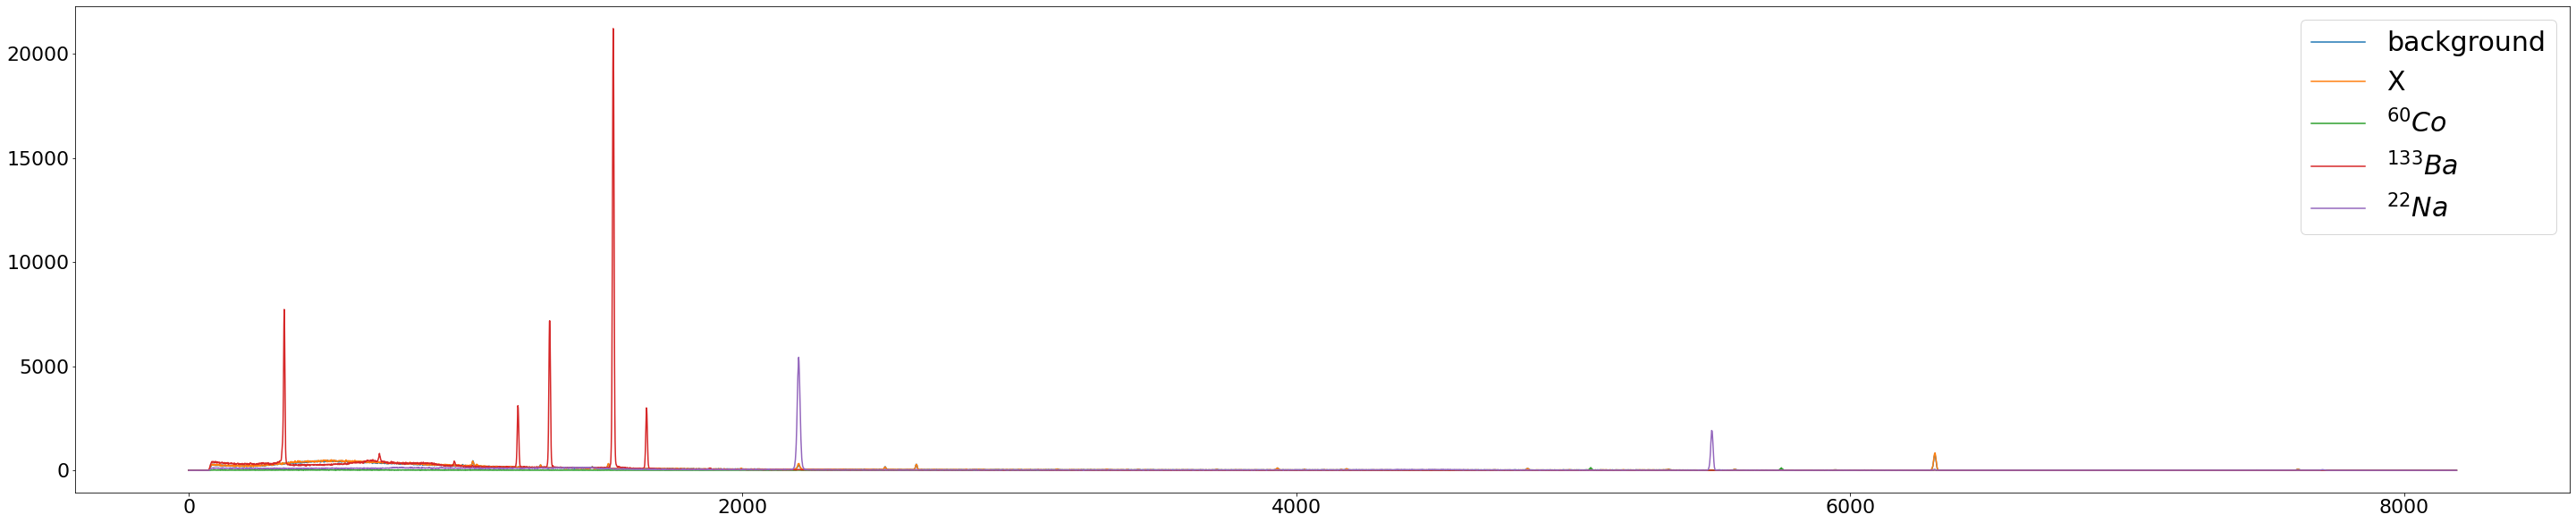

In [137]:
plt.figure(figsize=(50, 10))


plt.plot(spectrum_bkg, label=r'background')
plt.plot(spectrum_x, label=r'X')
plt.plot(spectrum_co60, label=r'$^{60}Co$')
plt.plot(spectrum_ba133, label=r'$^{133}Ba$')
plt.plot(spectrum_na22, label=r'$^{22}Na$')

plt.legend(fontsize=30)
# plt.ylim(0, 1000)


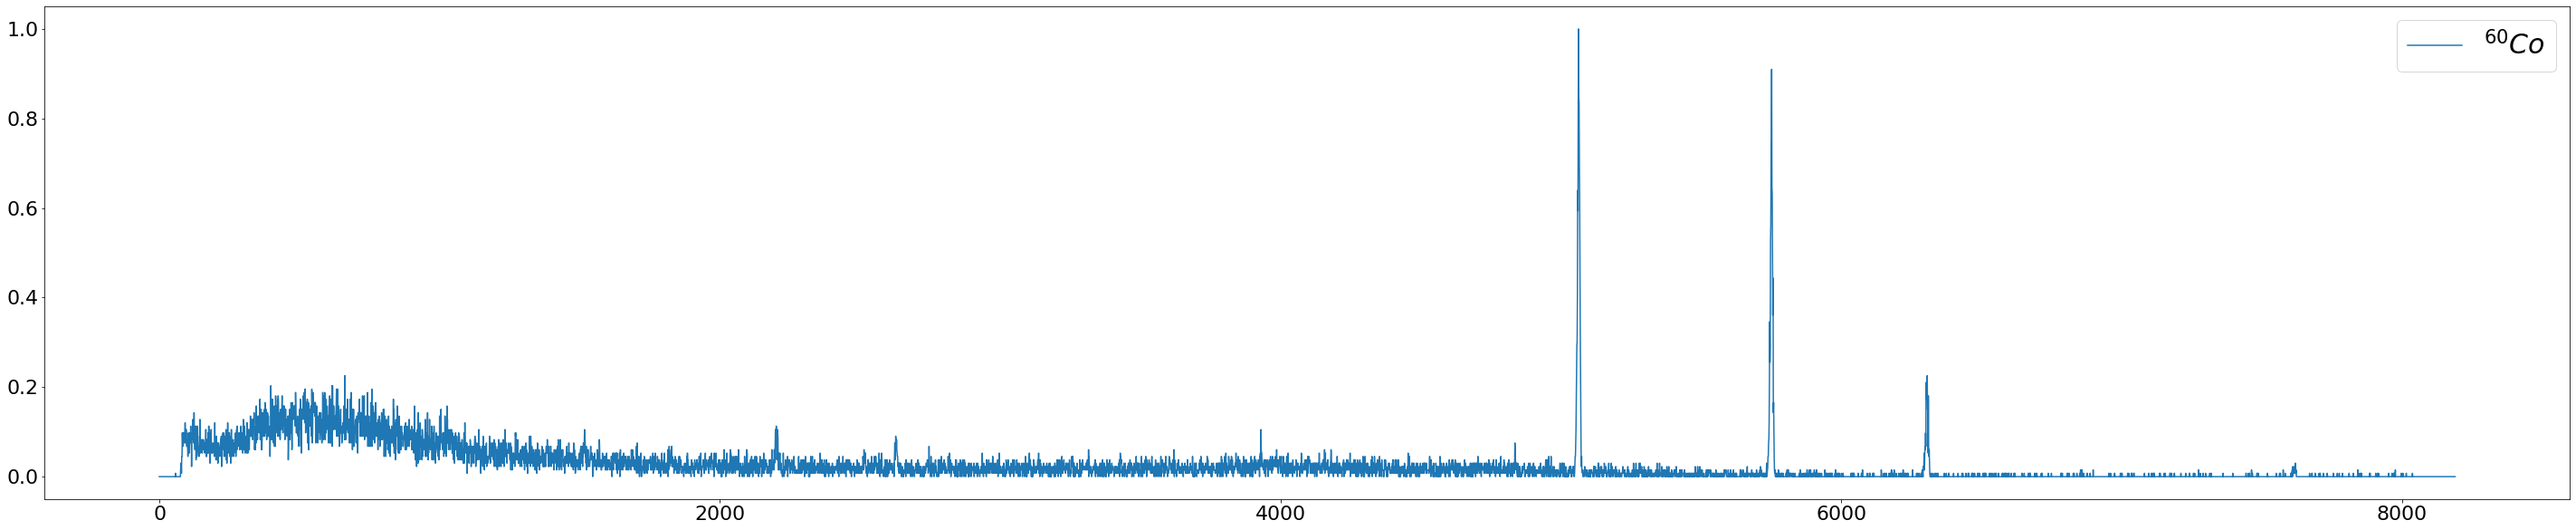

In [138]:
plt.figure(figsize=(50, 10))


# plt.plot(spectrum_bkg/max(spectrum_bkg), label=r'background')
# plt.plot(spectrum_x/max(spectrum_x), label=r'X')
plt.plot(spectrum_co60/max(spectrum_co60), label=r'$^{60}Co$')
# plt.plot(spectrum_ba133/max(spectrum_ba133), label=r'$^{133}Ba$')
# plt.plot(spectrum_na22/max(spectrum_na22), label=r'$^{22}Na$')

plt.legend(fontsize=30)

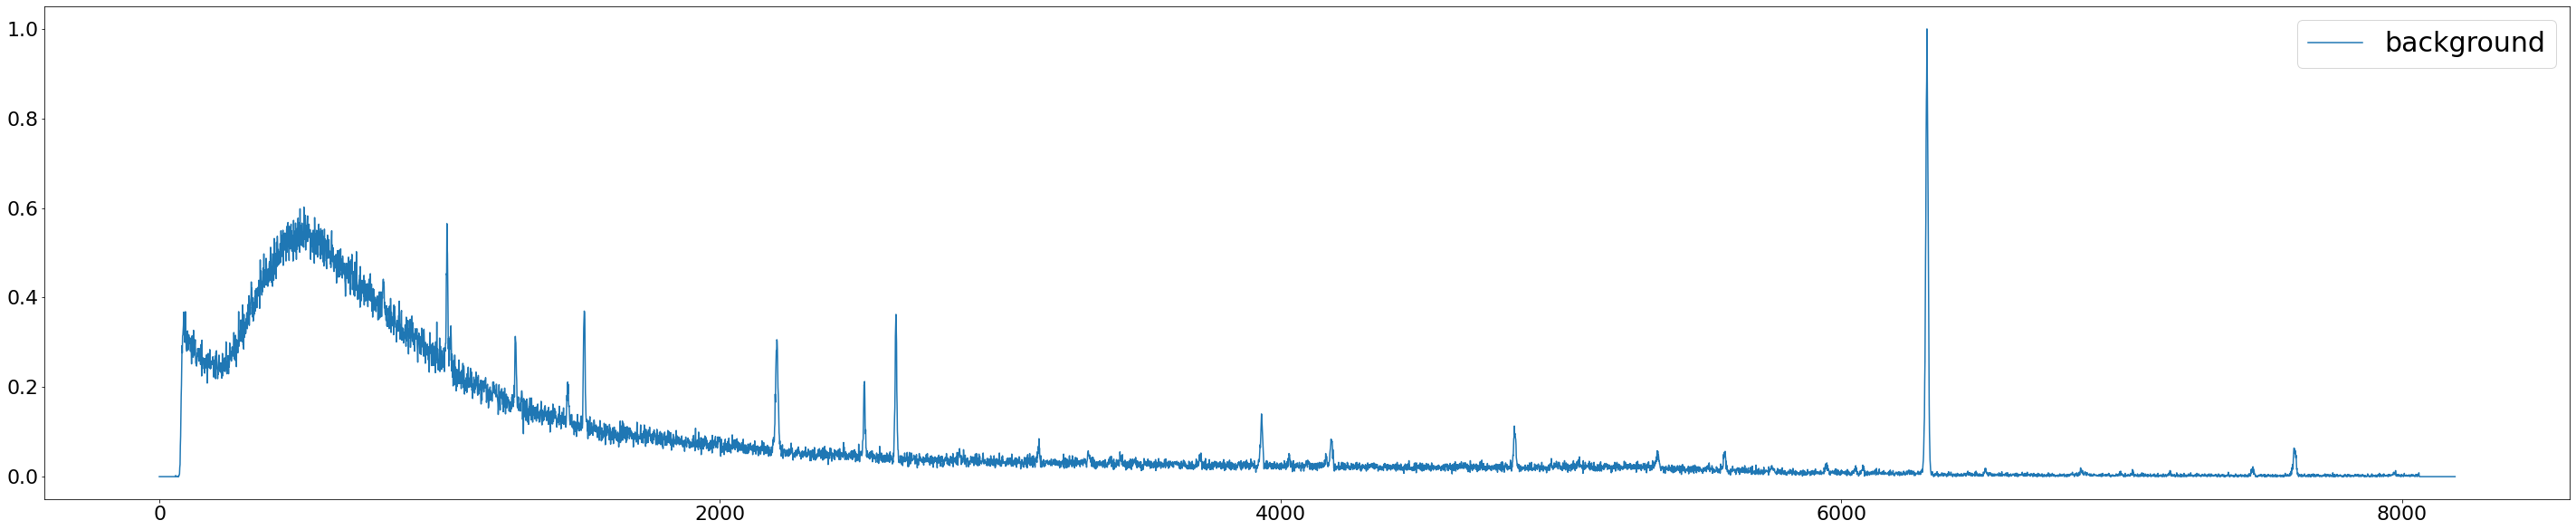

In [139]:
plt.figure(figsize=(50, 10))


plt.plot(spectrum_bkg/max(spectrum_bkg), label=r'background')
# plt.plot(spectrum_x/max(spectrum_x), label=r'X')
# plt.plot(spectrum_co60/max(spectrum_co60), label=r'$^{60}Co$')
# plt.plot(spectrum_ba133/max(spectrum_ba133), label=r'$^{133}Ba$')
# plt.plot(spectrum_na22/max(spectrum_na22), label=r'$^{22}Na$')

plt.legend(fontsize=30)

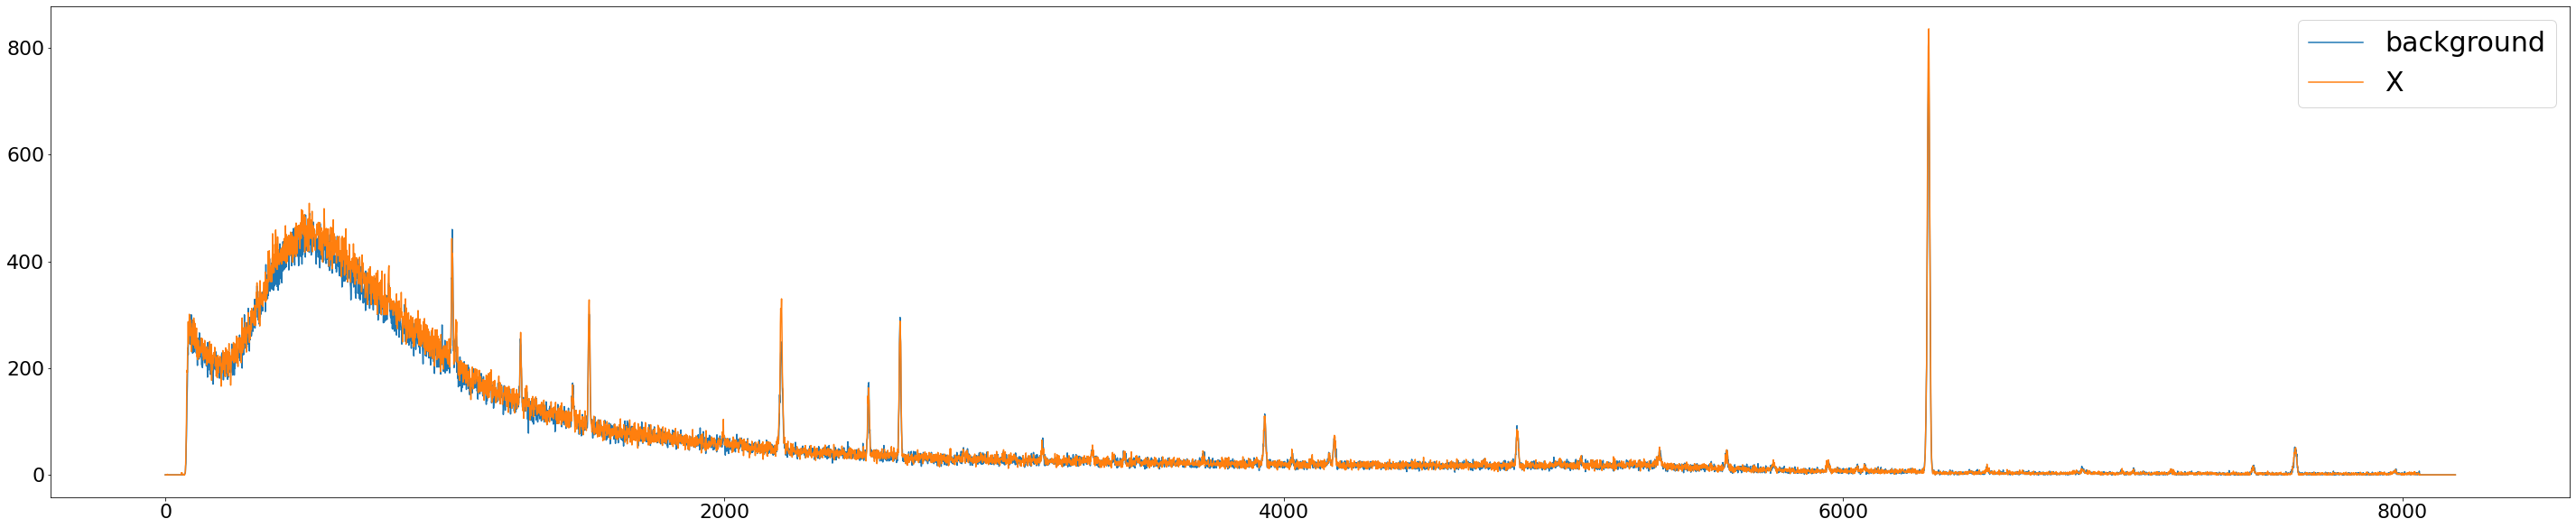

In [140]:
plt.figure(figsize=(50, 10))


plt.plot(spectrum_bkg, label=r'background')
plt.plot(spectrum_x, label=r'X')
# plt.plot(spectrum_co60/max(spectrum_co60), label=r'$^{60}Co$')
# plt.plot(spectrum_ba133/max(spectrum_ba133), label=r'$^{133}Ba$')
# plt.plot(spectrum_na22/max(spectrum_na22), label=r'$^{22}Na$')

plt.legend(fontsize=30)

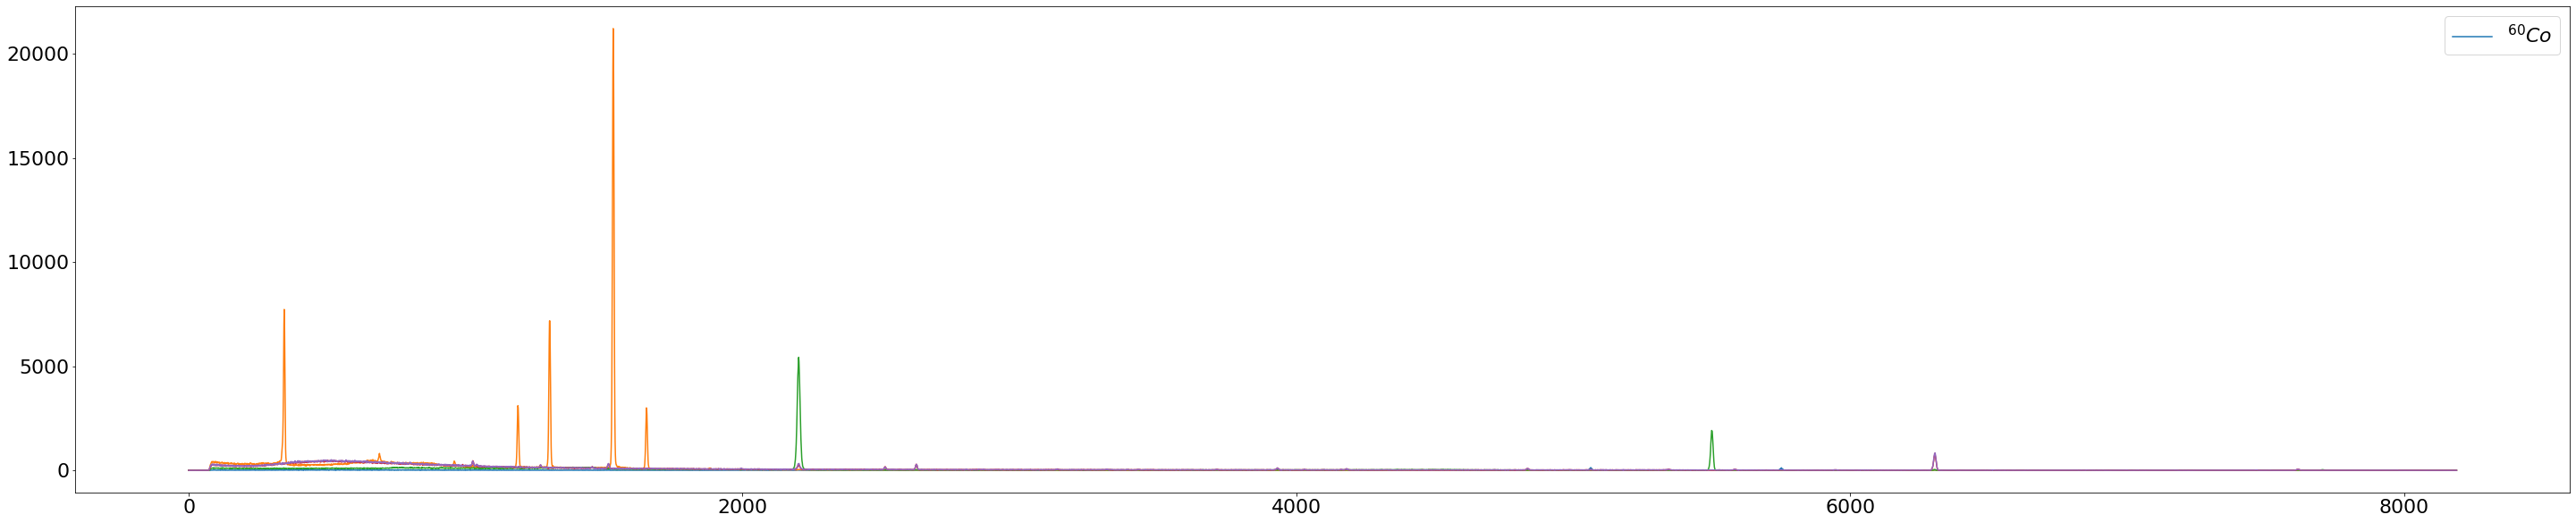

In [141]:
plt.figure(figsize=(50, 10))

plt.plot(spectrum_co60, label=r'$^{60}Co$')
plt.plot(spectrum_ba133)
plt.plot(spectrum_na22)
plt.plot(spectrum_bkg)
plt.plot(spectrum_x)

plt.legend()

[5063 5752]
[(4948, 5048), (5079, 5179), (5635, 5735), (5765, 5865)]


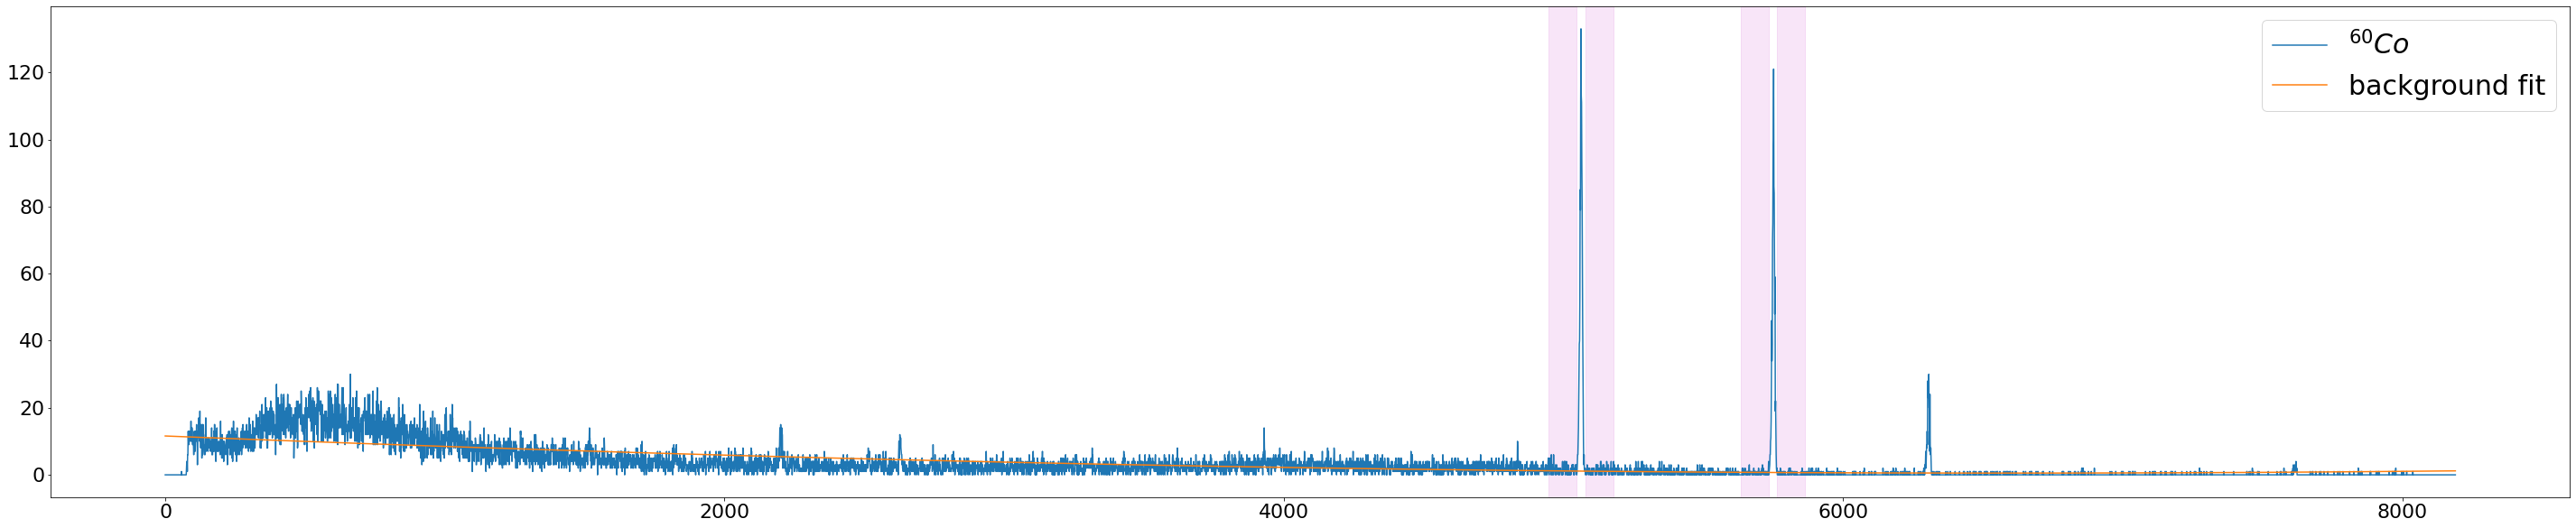

In [87]:
plt.figure(figsize=(50, 10))


# plt.plot(spectrum_bkg, label=r'background')
# plt.plot(spectrum_x, label=r'X')
plt.plot(spectrum_co60, label=r'$^{60}Co$')

from scipy.signal import find_peaks

peaks, properties = find_peaks(spectrum_co60, prominence=100, width=5)
print(peaks)
left_bases = properties["left_bases"]
right_bases = properties["right_bases"]
# plt.plot(spectrum_ba133, label=r'$^{133}Ba$')
# plt.plot(spectrum_na22, label=r'$^{22}Na$')
background_width = 100
background_regions = []
for peak, left_base, right_base in zip(peaks, left_bases, right_bases):
    background_regions.append((left_base - background_width, left_base))
    background_regions.append((right_base, right_base + background_width))

print(background_regions)

mask_bkg1 = np.ones(len(channels), dtype=bool)

# ()^((channels>4250)*(channels<4750))^((channels>4830)*(channels<5000))
    
for start, stop in background_regions:
    plt.axvspan(start, stop,  alpha=0.1, color='m')
    mask_bkg1 = mask_bkg1^((channels>start)*(channels<stop))

coeff = np.polyfit(channels[mask_bkg1], spectrum_co60[mask_bkg1], 2)
bkgfit = np.polyval(coeff, channels)

plt.plot(channels, bkgfit, label='background fit')

plt.legend(fontsize=30)
# plt.ylim(0, 1000)
#plt.xlim(5000, 6000)

In [88]:
from scipy.optimize import curve_fit

In [89]:
def gauss(x, *p):
    A, t0, v = p
    return A*np.exp(-(x-t0)**2/(2.*v))

def comb_gauss(x, *p):
    distr = 0
    for j in range(2):
        distr += gauss(x, *[p[j*3],p[j*3+1],p[j*3+2]])
    return distr

coeff_gauss, _ = curve_fit(comb_gauss, channels, spectrum_co60-bkgfit, p0=[100, peaks[0], 10, 100, peaks[1], 10])
fit_hist = comb_gauss(channels, *coeff_gauss)


[5063 5752]
[(4948, 5048), (5079, 5179), (5635, 5735), (5765, 5865)]


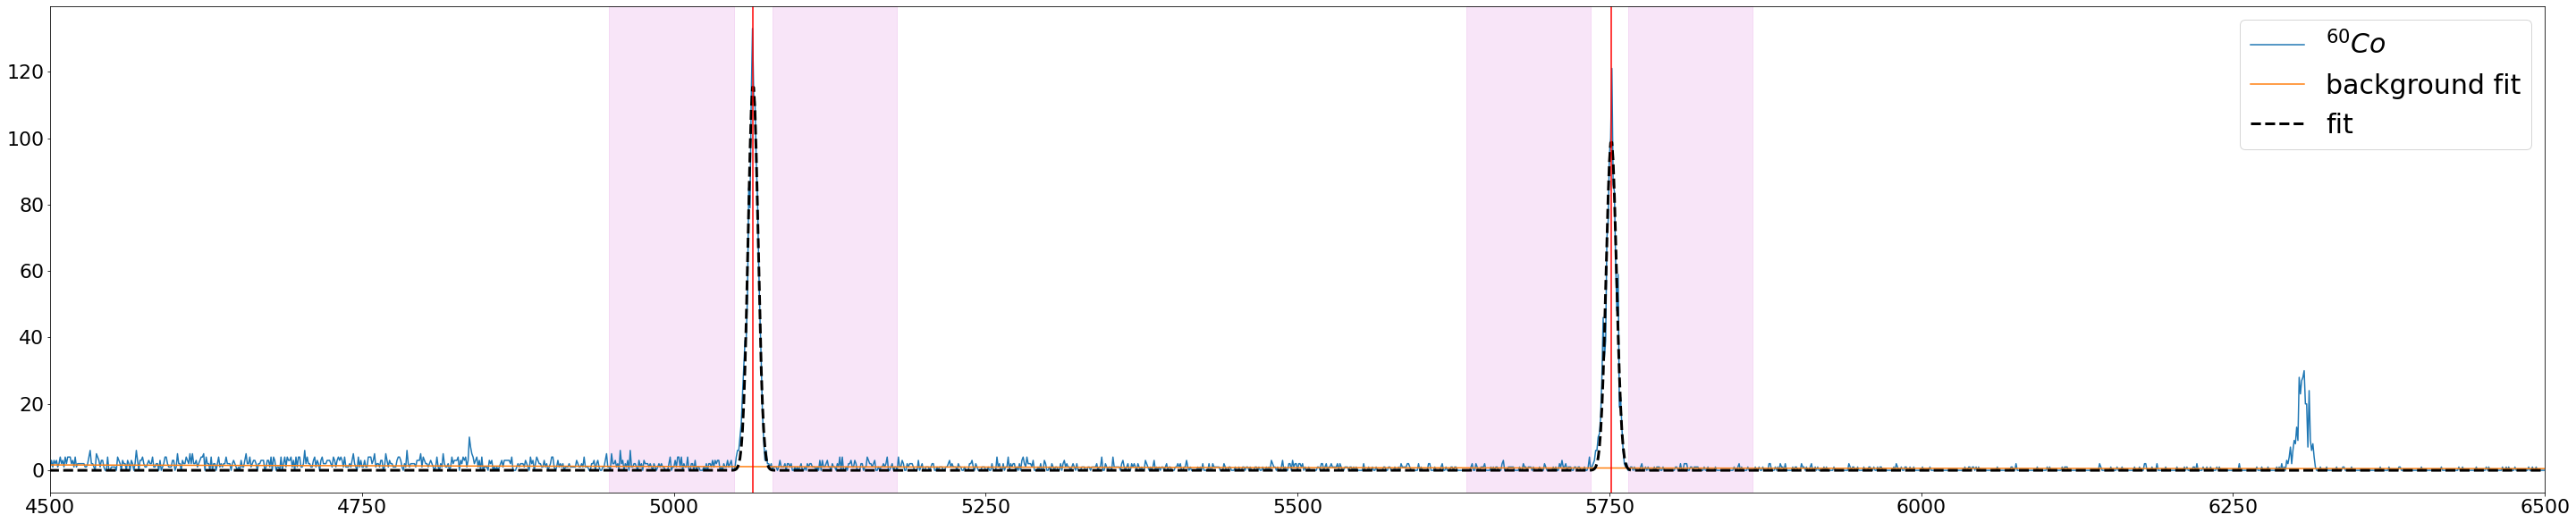

In [90]:
plt.figure(figsize=(50, 10))


# plt.plot(spectrum_bkg, label=r'background')
# plt.plot(spectrum_x, label=r'X')
plt.plot(spectrum_co60, label=r'$^{60}Co$')

from scipy.signal import find_peaks

peaks, properties = find_peaks(spectrum_co60, prominence=100, width=5)
print(peaks)
left_bases = properties["left_bases"]
right_bases = properties["right_bases"]
# plt.plot(spectrum_ba133, label=r'$^{133}Ba$')
# plt.plot(spectrum_na22, label=r'$^{22}Na$')
background_width = 100
background_regions = []
for peak, left_base, right_base in zip(peaks, left_bases, right_bases):
    background_regions.append((left_base - background_width, left_base))
    background_regions.append((right_base, right_base + background_width))

print(background_regions)

mask_bkg1 = np.ones(len(channels), dtype=bool)

# ()^((channels>4250)*(channels<4750))^((channels>4830)*(channels<5000))
    
for start, stop in background_regions:
    plt.axvspan(start, stop,  alpha=0.1, color='m')
    mask_bkg1 = mask_bkg1^((channels>start)*(channels<stop))

coeff = np.polyfit(channels[mask_bkg1], spectrum_co60[mask_bkg1], 2)
bkgfit = np.polyval(coeff, channels)

plt.plot(channels, bkgfit, label='background fit')

plt.plot(channels, fit_hist, c='k', lw=3, ls='--', label="fit")

plt.axvline(coeff_gauss[1], c='r')
plt.axvline(coeff_gauss[4], c='r')


plt.legend(fontsize=30)
# plt.ylim(0, 1000)
plt.xlim(4500, 6500)
plt.show()

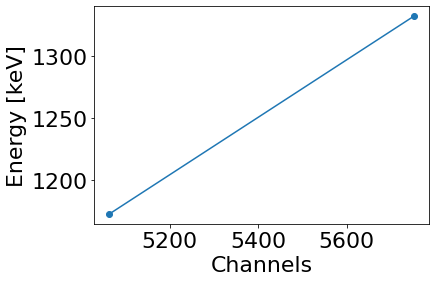

In [91]:

#what peaks do we need to match?
Co60_Peaks = [1173, 1332]  # keV
# Ba133_Peaks = [356]
# Na22_Peaks = [511, 1274]

plt.plot([coeff_gauss[1],coeff_gauss[4]], Co60_Peaks, '-o')
plt.ylabel("Energy [keV]")
plt.xlabel("Channels")
plt.show()

In [92]:
coeff_gauss

array([ 116.20861144, 5063.48836728,   15.95359057,   99.39877168,
       5751.52040212,   17.01252173])

In [93]:
cal1 = np.polyfit([coeff_gauss[1],coeff_gauss[4]], [1173, 1332], 1)

#convert our channel values to energy values for the x axis based off the results of the 
channelToEnergy = np.polyval(cal1, channels)

In [94]:
# cal1

In [95]:
# 0.277*4200+1.8287

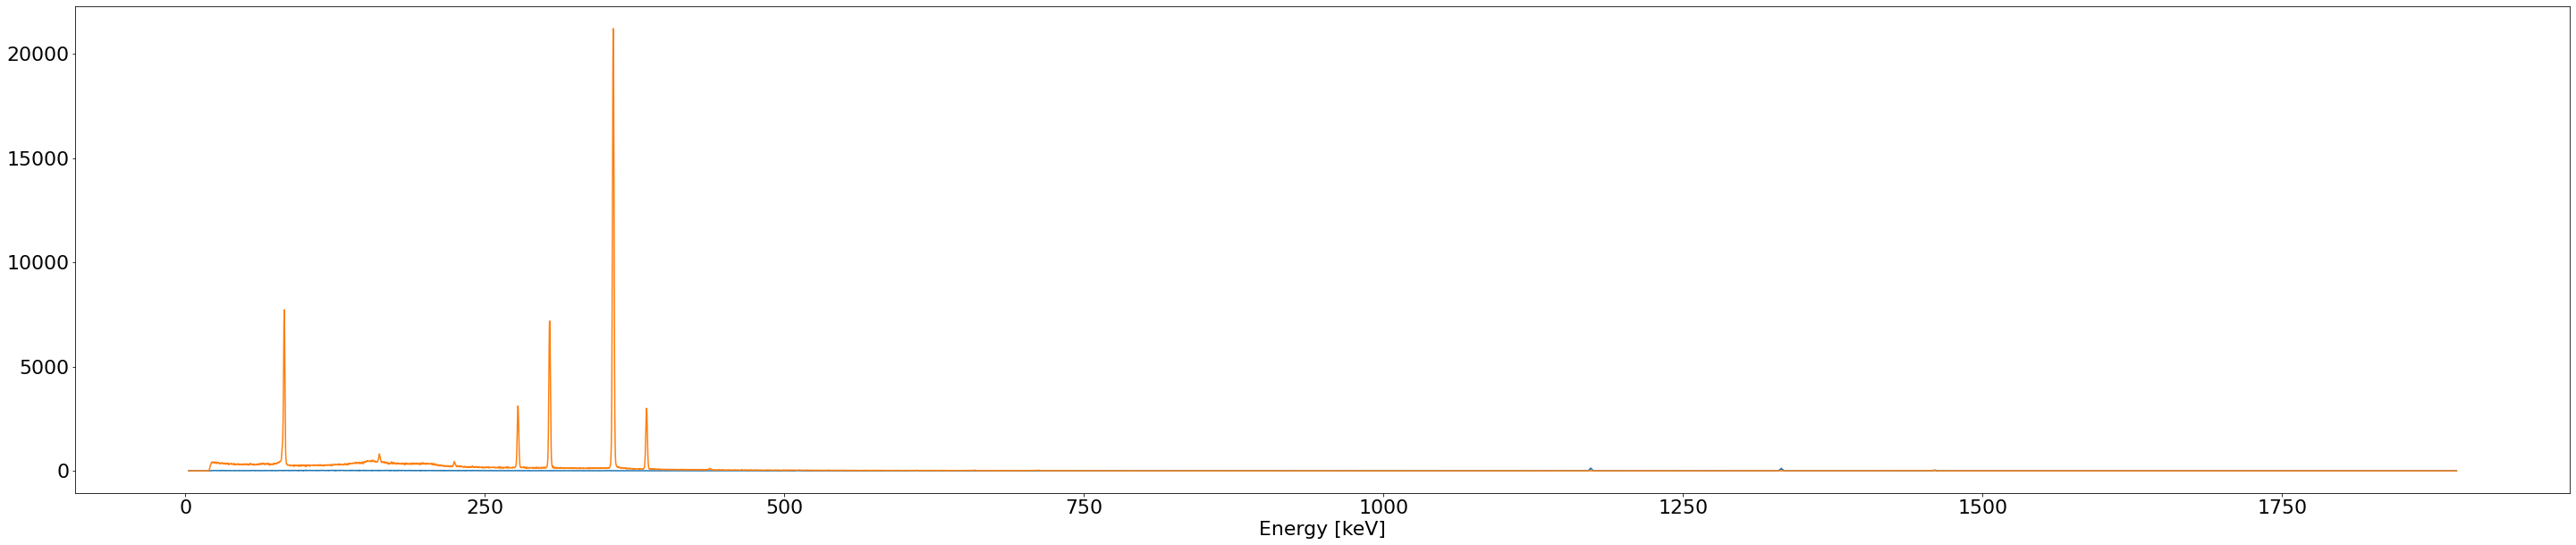

In [96]:
plt.figure(figsize=(50, 10))

# plt.plot(spectrum_bkg, label=r'background')
# plt.plot(spectrum_x, label=r'X')
plt.plot(channelToEnergy, spectrum_co60, label=r'$^{60}Co$')
plt.plot(channelToEnergy, spectrum_ba133, label=r'$^{133}Ba$')
# plt.plot(spectrum_na22, label=r'$^{22}Na$')
plt.xlabel("Energy [keV]")
plt.show()

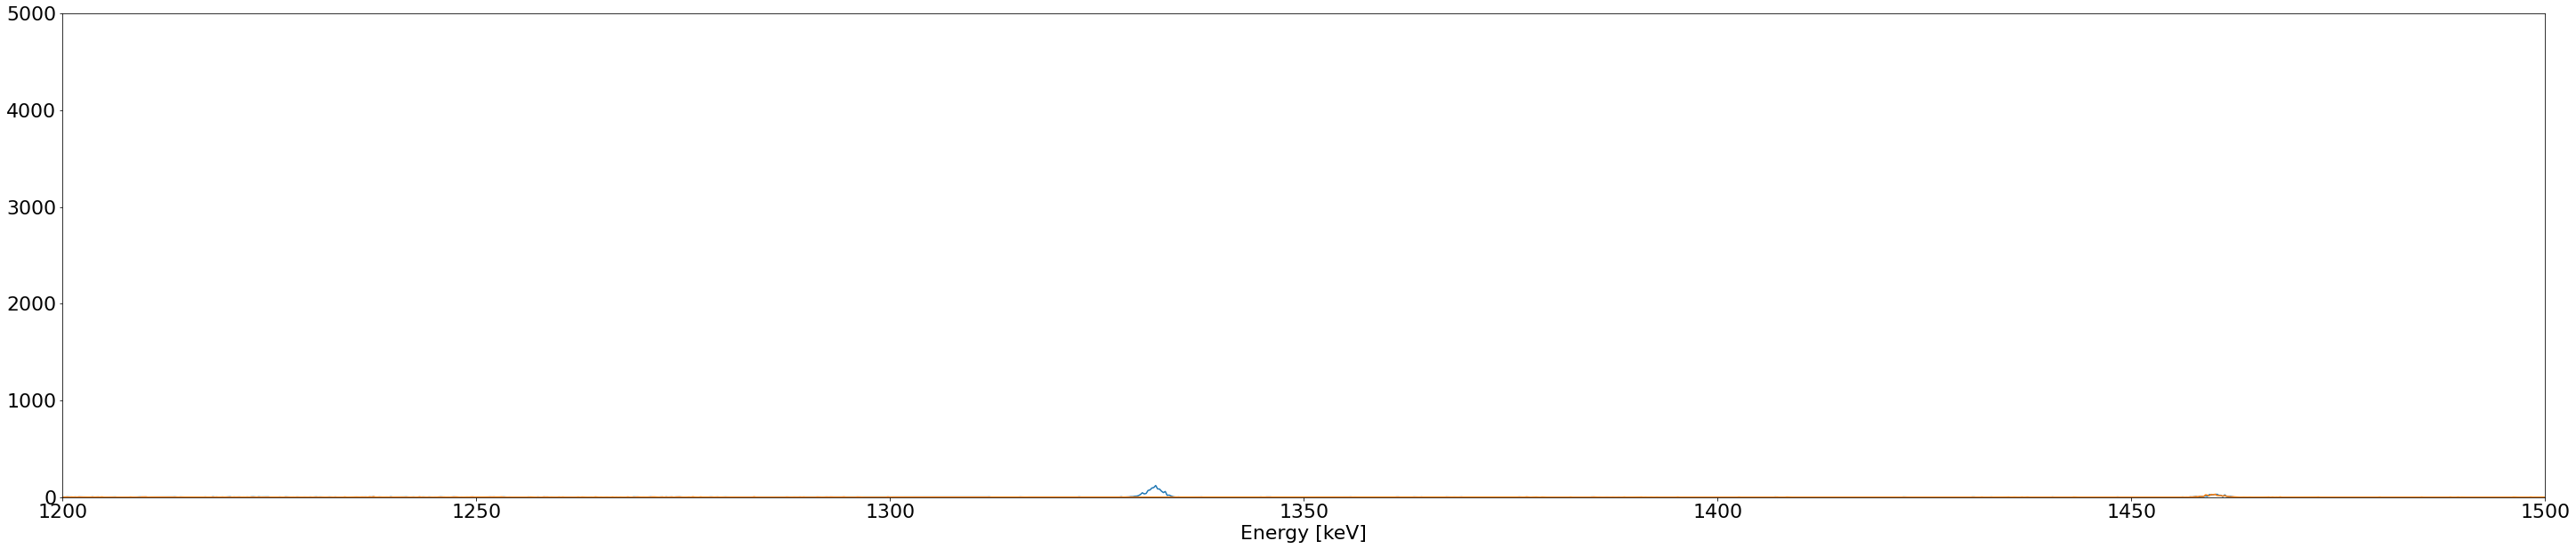

In [97]:
plt.figure(figsize=(50, 10))


# plt.plot(spectrum_bkg, label=r'background')
# plt.plot(spectrum_x, label=r'X')
plt.plot(channelToEnergy, spectrum_co60, label=r'$^{60}Co$')
plt.plot(channelToEnergy, spectrum_ba133, label=r'$^{133}Ba$')
# plt.plot(spectrum_na22, label=r'$^{22}Na$')
plt.xlabel("Energy [keV]")
plt.ylim(0, 5000)
plt.xlim(1200, 1500)
plt.show()

(0.0, 500.0)

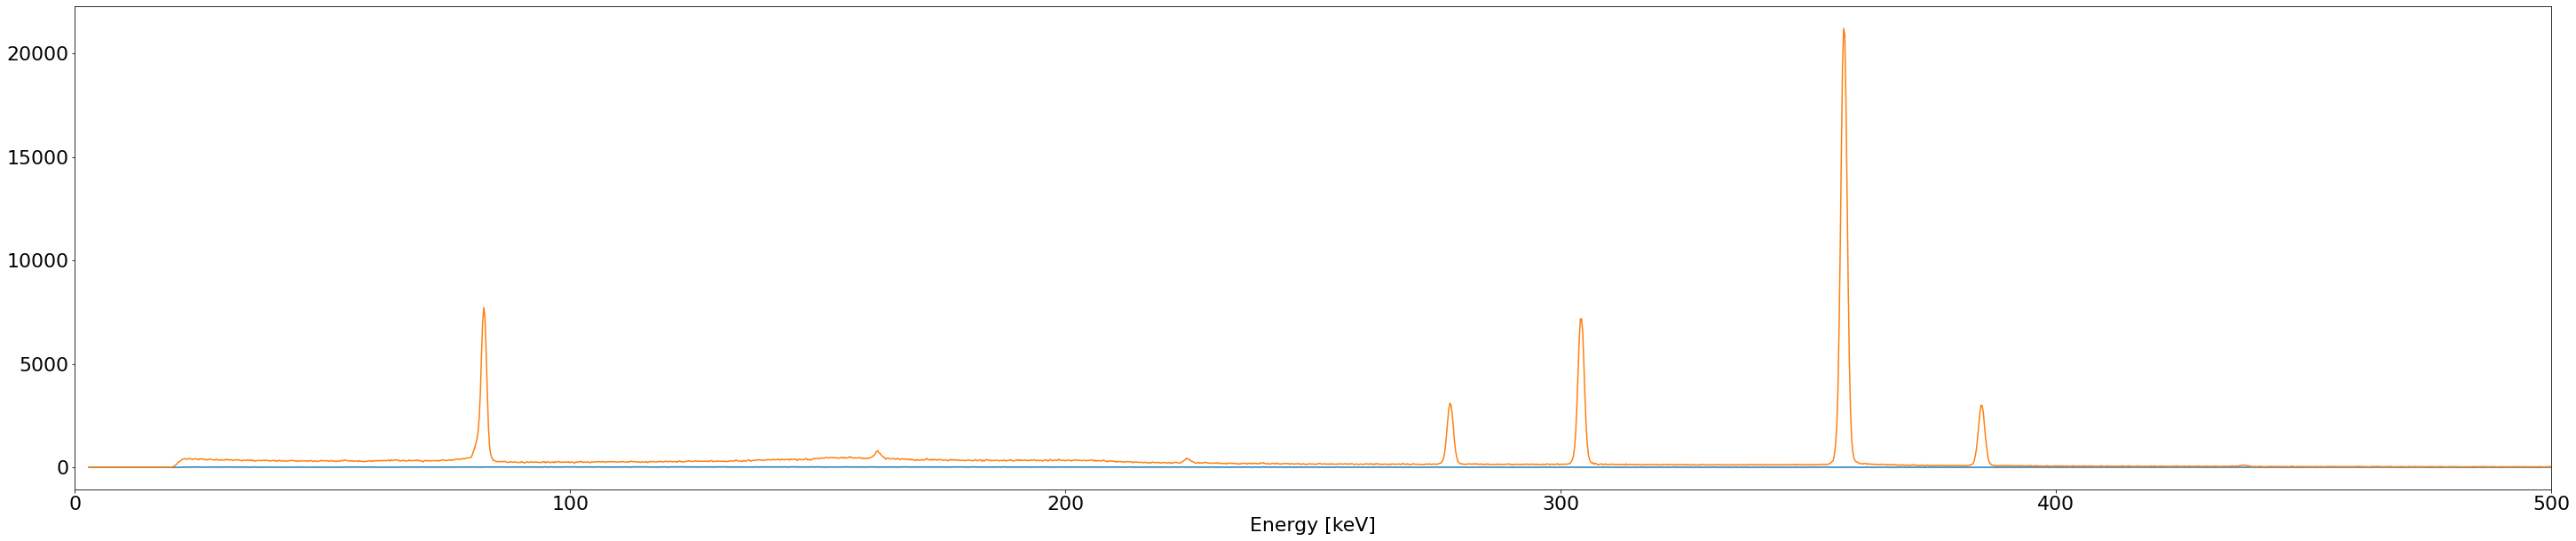

In [98]:
plt.figure(figsize=(50, 10))


# plt.plot(spectrum_bkg, label=r'background')
# plt.plot(spectrum_x, label=r'X')
plt.plot(channelToEnergy, spectrum_co60, label=r'$^{60}Co$')
plt.plot(channelToEnergy, spectrum_ba133, label=r'$^{133}Ba$')
# plt.plot(spectrum_na22, label=r'$^{22}Na$')

plt.xlabel("Energy [keV]")
plt.xlim(0, 500)

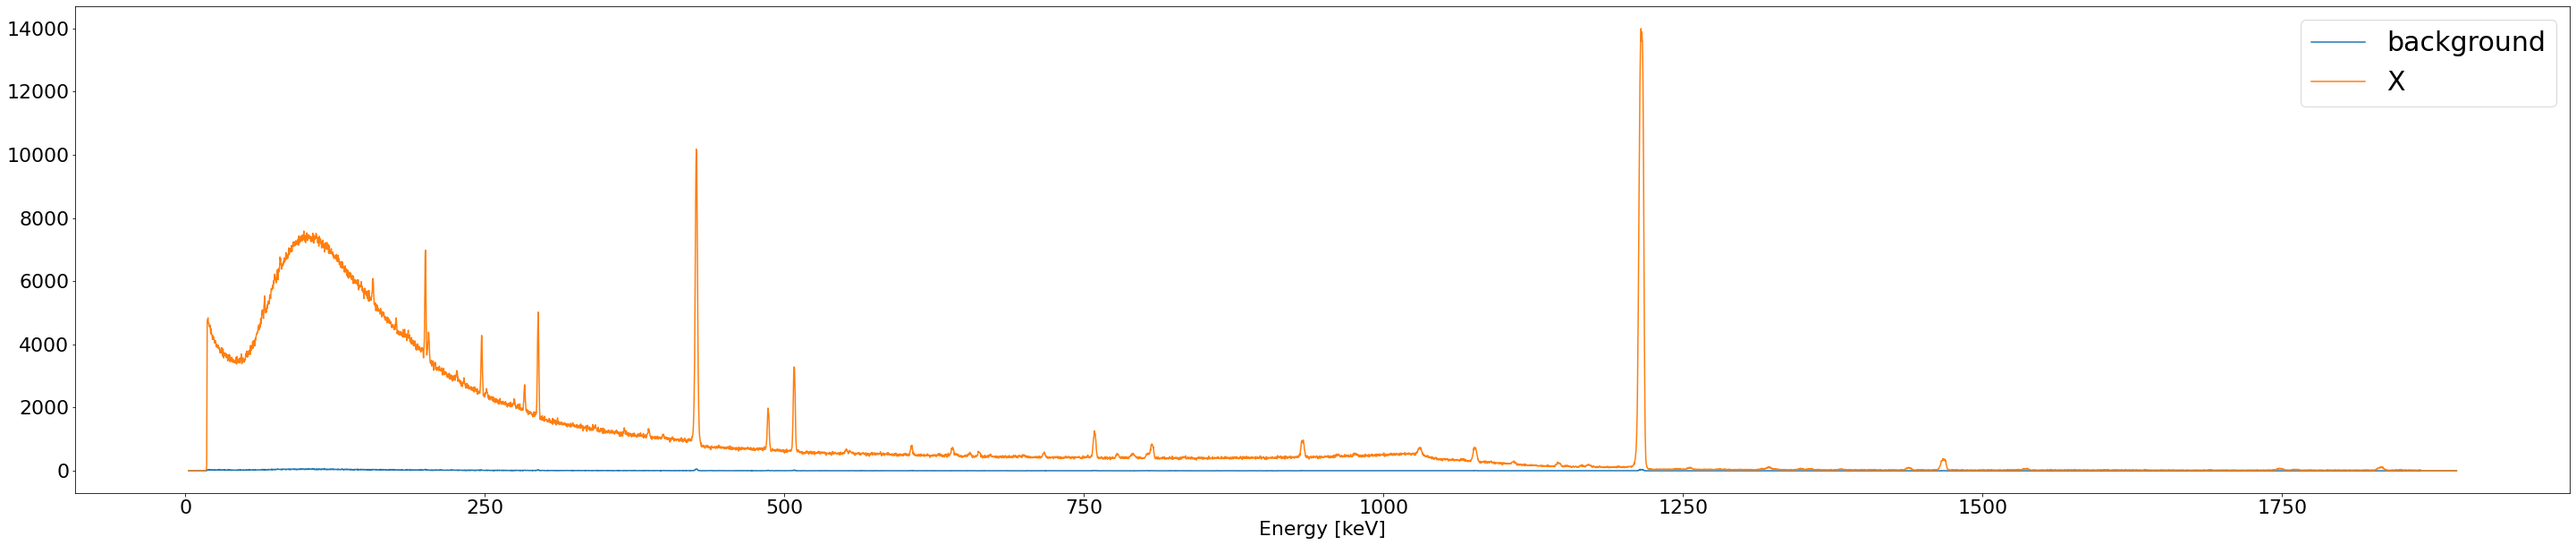

In [99]:
plt.figure(figsize=(50, 10))


plt.plot(channelToEnergy,spectrum_bkg, label=r'background')
plt.plot(channelToEnergy,spectrum_x, label=r'X')
# plt.plot(spectrum_co60/max(spectrum_co60), label=r'$^{60}Co$')
# plt.plot(spectrum_ba133/max(spectrum_ba133), label=r'$^{133}Ba$')
# plt.plot(spectrum_na22/max(spectrum_na22), label=r'$^{22}Na$')
plt.xlabel("Energy [keV]")
plt.legend(fontsize=30)

In [100]:
# ?np.polyfit

In [101]:
### summing up peaks to get total areas of counts

coeff_gauss_E, _ = curve_fit(comb_gauss, channelToEnergy, spectrum_co60-bkgfit, p0=[100, 1173, 3, 100, 1332, 3])
fit_hist_E = comb_gauss(channelToEnergy, *coeff_gauss_E)

#splits our array up, cutting whereever there is a entry, and making sure we cut the 
#energy array the same way
fit_hist_E_split = np.array(np.split(fit_hist_E, np.where(fit_hist_E == 0)[0][1:]), dtype=object)
channelToEnergy_split = np.array(np.split(channelToEnergy, np.where(fit_hist_E == 0)[0][1:]), dtype=object)

#remove all arrays that are length 1 or less
lengths = [len(i)>1 for i in fit_hist_E_split]

#a 2D array holding the values around each peak
fit_hist_E_peaks = fit_hist_E_split[lengths]
channelToEnergyPeaks = channelToEnergy_split[lengths]

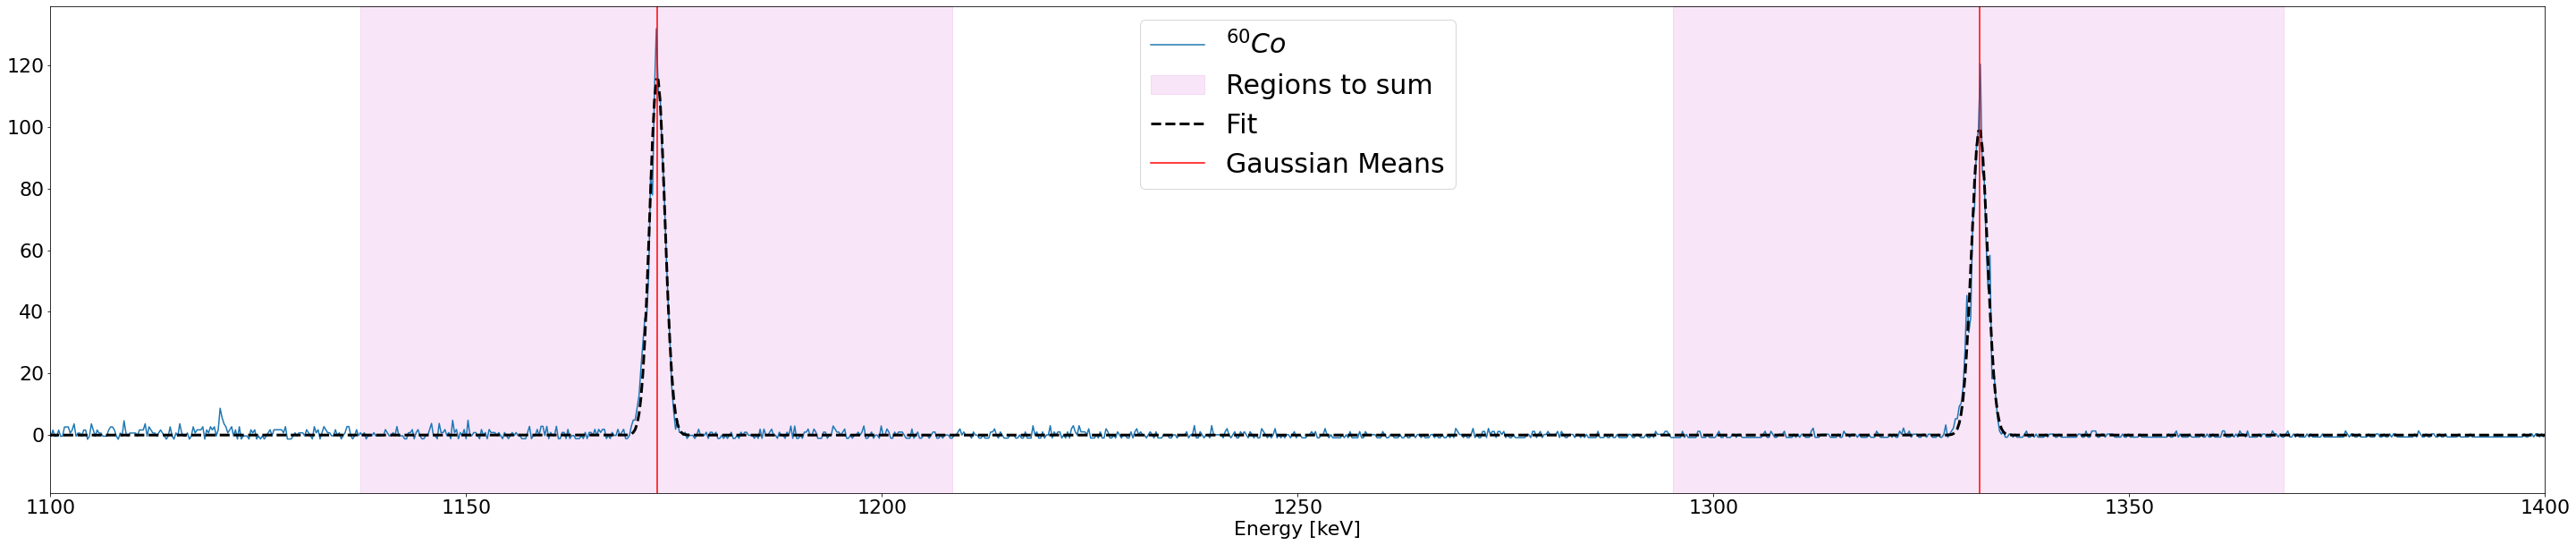

In [102]:
plt.figure(figsize=(50, 10))

plt.plot(channelToEnergy, spectrum_co60-bkgfit, label=r'$^{60}Co$')

#get the min and max energy values that we will sum around for plotting
minMaxEnergyValues = [[np.min(x), np.max(x)] for x in channelToEnergyPeaks]

#empty region just to hold the label
plt.axvspan(0, 0, alpha=0.1, color='m', label="Regions to sum")

for vals in minMaxEnergyValues:
    plt.axvspan(vals[0], vals[1], alpha=0.1, color='m')

plt.plot(channelToEnergy, fit_hist_E, c='k', lw=3, ls='--', label="Fit")

plt.axvline(coeff_gauss_E[1], c='r', label="Gaussian Means")
plt.axvline(coeff_gauss_E[4], c='r')

plt.legend(fontsize=30)
plt.xlim(1100, 1400)

plt.xlabel("Energy [keV]")
plt.show()

In [103]:
#takes in sprectrum that is alreay cut for only one peak
def SumPeaks(x, spectrum):
    
    #the width of one bin
    binwidth = x[2] - x[1]
    
    #sum up all our bins in a region
    totalArea = np.sum(spectrum)*binwidth
    
    return totalArea

#loop through all the peaks and calculate the area under the curve
AreaPeaks = []

for i, peakData in enumerate(fit_hist_E_peaks):
    
    AreaPeaks.append(SumPeaks(channelToEnergyPeaks[i], peakData))
    
print("The total area under each peak is:", AreaPeaks)

The total area under each peak is: [268.87127847053574, 237.49035634455444]


In [104]:
'''
Returns current activity in Bq
inputs:
    A0 [Bq]
    time [days]
    half_life [days]
'''

def currentActivity(A0, time, half_life):
    return A0*np.exp(-(time*np.log(2))/half_life)

Na22_currentAct = currentActivity(37e3, 762, 2.6018*365)
print(Na22_currentAct)

Co66_currentAct = currentActivity(3.7e5, 16390, 1925.28)
print(Co66_currentAct)

Ba133_currentAct = currentActivity(3.81e5, 6925, 10.551*365)
print(Ba133_currentAct)

21215.67088952769
1012.789257614295
109551.59360259165
